In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

# Load ETL character data
import os
import io
import json
import bitstring
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import IPython.display as display
import shared

## Load the data and inspect a sample

Thanks to instructions at [this GitHub page](https://github.com/ichisadashioko/etlcdb/blob/master/inspect-etl2.ipynb)

In [15]:
filepaths = [
    'data/ETL2_1', 
    'data/ETL2_2',
    'data/ETL2_3',
    'data/ETL2_4',
    'data/ETL2_5']

for filepath in filepaths:
    if not os.path.exists(filepath):
        raise Exception(filepath, 'does not exist!')

In [17]:
sample_filepath = filepaths[0]
sample_filepath

'data/ETL2_1'

In [18]:
IMG_WIDTH = 60
IMG_HEIGHT = 60

bitstring_unpack_str = ','.join([
    'int:36', # Serial Index - [0]
    'uint:6', # Source ('A': Mincho Newspaper, 'B': Gothic Newspaper, 'C': Mincho Patent, 'D': Gothic Patent) - [1]
    'pad:30', # padding bits - no index as they are skipped
    '6*uint:6', # Class ('KANJI': kanji, 'EIJI': roman alphabets, 'HRKANA': hiragana, 'KTKANA': katakana, 'KIGO': special characters, 'SUUJI': numbers) - [2:8]
    '6*uint:6', # Font ('MINCHO', 'GOTHIC') - [8:14]
    'pad:24', # padding bits
    '2*uint:6', # CO-59 Code - [14:16]
    'pad:180', # padding bits
    'bytes:2700', # 6-bit-depth image of 60 x 60 = 3600 pixels - [16]
])

In [19]:
infile = bitstring.ConstBitStream(filename=sample_filepath)
unpacked_data = infile.readlist(bitstring_unpack_str)

print(type(unpacked_data), len(unpacked_data))
print(unpacked_data[:-1])

<class 'list'> 17
[1, 17, 34, 17, 37, 33, 25, 16, 36, 25, 37, 19, 24, 38, 4, 4]


In [22]:
print(
    unpacked_data[0],
    shared.T56(unpacked_data[1]),
    ''.join(map(shared.T56, unpacked_data[2:8])),
    ''.join(map(shared.T56, unpacked_data[8:14])),
    shared.CO59[tuple(unpacked_data[14:16])],
)

1 A KANJI  MINCHO 上


In [23]:
class ETL2Record:
    def __init__(
        self,
        index: int, # the Serial Index in the record
        source: str, # the source material that the record has been scanned from
        character_type: str, # enum type: 'KANJI', 'EIJI', 'HRKANA', 'KTKANA', 'KIGO', 'SUUJI'
        font: str, # e.g. "('MINCHO', 'GOTHIC')"
        unicode_char: str, # e.g. あ
        image: bytes, # PNG encoded image
    ):
        self.index = index
        self.source = source
        self.character_type = character_type
        self.font = font
        self.unicode_char = unicode_char
        self.image = image

    def __repr__(self):
        return repr(self.__dict__)

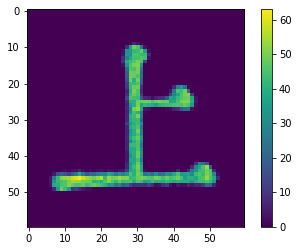

In [25]:
pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), unpacked_data[16], 'bit', 6)

np_img = np.array(pil_image)

plt.imshow(np_img)
plt.colorbar()

## Convert image to grayscale

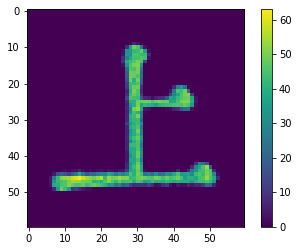

In [26]:
pil_image = pil_image.convert('L')
np_img = np.array(pil_image)

plt.imshow(np_img)
plt.colorbar()

In [27]:
buffer = io.BytesIO()
pil_image.save(buffer, format='PNG')
png_encoded_image = buffer.getvalue()

In [29]:
pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), unpacked_data[16], 'bit', 6)
pil_image = pil_image.convert('L')

buffer = io.BytesIO()
pil_image.save(buffer, format='PNG')
png_encoded_image = buffer.getvalue()

etl2_record = ETL2Record(
    index=unpacked_data[0],
    source=shared.T56(unpacked_data[1]),
    character_type=''.join(map(shared.T56, unpacked_data[2:8])),
    font=''.join(map(shared.T56, unpacked_data[8:14])),
    unicode_char=shared.CO59[tuple(unpacked_data[14:16])],
    image=png_encoded_image,
)

etl2_record

{'index': 1, 'source': 'A', 'character_type': 'KANJI ', 'font': 'MINCHO', 'unicode_char': '上', 'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00<\x00\x00\x00<\x08\x00\x00\x00\x00\x1f\x97\x86\xae\x00\x00\x02\x12IDATx\x9c\xed\x95mk\xd4@\x10\xc7\xe7i7\xc9\xb5\x9cT\xad-\xf5\x01\xbf\xffG\x12\n\x15\x04\xc1*"w\xd7\\\xb2\xb33\xbe\xf0\xae\x90\xd6N\x8f\x08\xbe\xbay\x13\x92\xff\xfc\xb2;\xff\x9d\xdd\x058\xc61\xfe%0s\xac\x07Z\xfbv\xa9\xb7\xb7\xf5\xe9\x04zZ\xe2K\x1f\xec\xf2c\x90\x11H@\xc646i\x16\x9cJr\x17\xd2Y0.2e\xb8\x99W\xf38\x92\xe0j\xfdtB\x04\xd7\r\x16\xdf\x06,H\xa0)\xbb\x07\x15\xc7n\x03\x80\x86z$\x1ale\xf6\xc8:\x92\xfa\xfd\xdb_z1\xaa\xd9=c\xbf\x7fi\xce\x9b\xd5\xadO\x13"\xb8\x18\x15\xdb\xe7\xbd<\xb3%|\x9b&\x84\xed\xc9\xb6\xff9v\xb2%|\x7fz\xf8\xc8\x89\xd4\x1bu\x15\xc2\xf6\xb5e4\xbc\xba\x9e\xf4[8\xed\x02\xdd\x07\x04e2\xd80\n\x02M]\x8b`+\t\xd7\xc9\\\x13a\x83X\xb8\xde[\xf0<\x8c\xe3\x92\xf1\x93W\x00@\x14\xea\x12~?\x1cv.\xfd\xaa:\x00\x80\xfb\x08\x8f\xdb<r\x1b[_\x90\x07\ta\xef\xba\x0fc\xa4G\xb

In [34]:
records_metadata = []
etl2_serialized_dataset_filepath = f'etl2{shared.XFormat.EXTENSION}'

if os.path.exists(etl2_serialized_dataset_filepath):
    raise Exception(etl2_serialized_dataset_filepath + ' already exists!')

with open(etl2_serialized_dataset_filepath, mode='wb') as out_stream:
    pbar = tqdm(filepaths)
    for filename in pbar:

        infile = bitstring.ConstBitStream(filename=filename)

        while True:
            try:
                unpacked_data = infile.readlist(bitstring_unpack_str)
            except:
                # TODO properly check for end of file
                # print(unpacked_data)
                # traceback.print_exc()
                break

            pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), unpacked_data[16], 'bit', 6)
            pil_image = pil_image.convert('L')

            buffer = io.BytesIO()
            pil_image.save(buffer, format='PNG')
            png_encoded_image = buffer.getvalue()

            etl2_record = ETL2Record(
                index=unpacked_data[0],
                source=shared.T56(unpacked_data[1]),
                character_type=''.join(map(shared.T56, unpacked_data[2:8])),
                font=''.join(map(shared.T56, unpacked_data[8:14])),
                unicode_char=shared.CO59[tuple(unpacked_data[14:16])],
                image=png_encoded_image,
            )

            record_datatype, serialized_record = shared.XFormat.serialize_obj(etl2_record.__dict__)
            record_byte_count = len(serialized_record)
            record_seek_start = out_stream.tell()

            out_stream.write(record_datatype)
            out_stream.write(shared.XFormat.serialize_int(record_byte_count))
            out_stream.write(serialized_record)

            record_seek_end = out_stream.tell()
            
            record_metadata = {
                'index': etl2_record.index,
                'source': etl2_record.source,
                'character_type': etl2_record.character_type,
                'font': etl2_record.font,
                'unicode_char': etl2_record.unicode_char,
                'seek_start': record_seek_start,
                'seek_end': record_seek_end,
            }
            
            records_metadata.append(record_metadata)
            
            pbar.set_description(f'{filename} - {etl2_record.index}')

data/ETL2_5 - 57600: 100%|██████████| 5/5 [03:18<00:00, 39.70s/it]


In [35]:
metadata_filepath = 'etl2-metadata.json'
if os.path.exists(metadata_filepath):
    raise Exception(metadata_filepath + ' already exists!')

with open(metadata_filepath, mode='w', encoding='utf-8') as out_stream:
    json.dump(records_metadata, out_stream, ensure_ascii=False, indent='\t')

In [48]:
len(unpacked_data)

17